# Titanic - Machine Learning from Disaster
Reference: [Kaggle Competition](https://www.kaggle.com/c/titanic/)

In [46]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings(action='ignore')

## Data Overview
* 결측치 존재
* 문자 데이터 존재

In [47]:
train_df = pd.read_csv('titanic/train.csv')
test_df = pd.read_csv('titanic/test.csv')
print(train_df.info())
print('-'*40)
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Pass

## 결측치 처리

In [48]:
print(train_df.isnull().sum())
print('-'*20)
print(test_df.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
--------------------
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


### Embarked
Embarked의 데이터는 연속값이 아닌, 구분값이므로 학습용 데이터(train_df)에서 2개의 결측값을 가장 빈번한 값으로 대체한다. <br>
데이터 분석 결과, S(Southampton)가 가장 많으므로 2개의 결측값을 S로 채운다. <br>
결과적으로 생존율에 영향을 미치지 않는다.
<br><br>
**그러나, 여기서 좀 더 깊게 들어가보자.** <br>
결측치가 존재하는 행을 살펴보면, 두 승객 모두 여성이며 80불의 경비를 지불했고, Pclass 1에 탑승했다. <br>
그렇다면, Pclass와 Embarked 피쳐에서 경비(Fare)가 어떻게 분포되어 있을까? <br><br>
아래 그림에서 알 수 있듯이, train_df와 test_df 모두에서 평균 80불 정도의 경비를 지불한 Pclass 1 승객들은 Embarked C에서 가장 많이 탑승했음을 알 수 있다. <br><br>
그러므로 사람들이 가장 많이 탑승한 S(Southampton)가 아닌 C(Cherbourg)로 결측치를 채울 것이다.

S    644
C    168
Q     77
Name: Embarked, dtype: int64


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


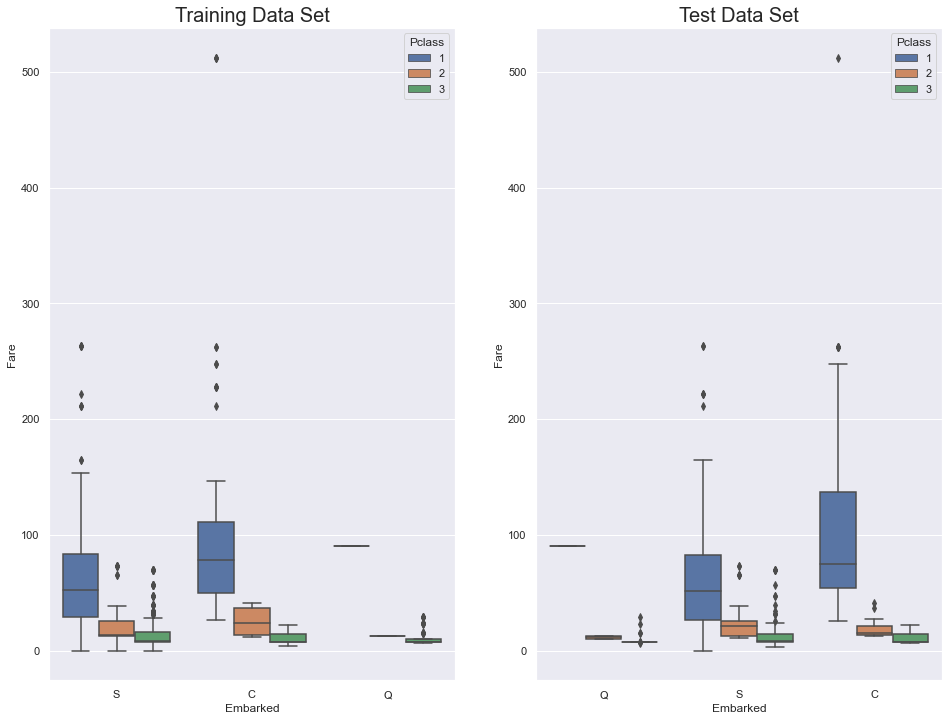

In [49]:
print(train_df['Embarked'].value_counts()) # S
display(train_df[train_df['Embarked'].isnull()])

sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(16,12), ncols=2)
fig_1 = sns.boxplot(x="Embarked", y="Fare", hue="Pclass", data=train_df, ax=ax[0])
fig_2 = sns.boxplot(x="Embarked", y="Fare", hue="Pclass", data=test_df, ax=ax[1])
fig_1.set_title("Training Data Set", fontsize=20)
fig_2.set_title("Test Data Set", fontsize=20)

train_df['Embarked'].fillna('C', inplace=True)

### Cabin
방번호(Cabin) 데이터는 결측값과 중복값이 많고 승객들이 하나의 방을 공유하는 경우도 있다. 무엇보다 생존 여부와 관계가 없으므로 제외할 것이다.

In [50]:
train_df.describe(include=['O'])
print('학습용 Cabin 결측비율: ' + str(train_df['Cabin'].isnull().sum() / len(train_df['Cabin'])))
print('테스트용 Cabin 결측비율: ' + str(test_df['Cabin'].isnull().sum()/len(test_df['Cabin'])))

train_df = train_df.drop('Cabin', axis=1)
test_df = test_df.drop('Cabin', axis=1)
display(train_df)
display(test_df)

학습용 Cabin 결측비율: 0.7710437710437711
테스트용 Cabin 결측비율: 0.7822966507177034


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S
...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S
...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,S


### Fare
* 최빈값 또는 중앙값으로 대체?
* [ Pclass: 3, Sex: male, Embarked: S ] 인 승객들의 평균 요금(Fare)값으로 대체

In [51]:
display(test_df[test_df['Fare'].isnull()])
missing_fare = test_df[(test_df['Pclass'] == 3) &
                       (test_df['Embarked'] == 'S') &
                       (test_df['Sex'] == 'male')]['Fare'].mean()
test_df['Fare'].fillna(missing_fare, inplace=True)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,S


### Age
`train_df`, `test_df`에서 모두 약 20% 정도의 결측치를 보이는데, '나이'는 생존율에 큰 영향을 미치므로 독립변수와의 상관관계를 고려하여 결측값을 대체할 것이다.

In [30]:
print('학습용 Age 결측비율: ' + str((train_df['Age'].isnull().sum()) / len(train_df)))
print('테스트용 Age 결측비율: ' + str((test_df['Age'].isnull().sum()) / len(test_df)))

학습용 Age 결측비율: 0.19865319865319866
테스트용 Age 결측비율: 0.20574162679425836


## Correlation Analysis
**[Assumptions]**
* Sex: 여성이 남성보다 생존율이 높을 것이다.
* Pclass: 높은 사회적/경제적 지위에 있을 수록 생존율이 높을 것이다.
* Age: 나이가 어릴 수록 생존율이 높을 것이다.
* Fare: 높은 승차 요금을 지불했을 경우 생존율이 높을 것이다. (Pclass와 높은 연관 관계를 보일 것이다.)
* SibSp, Parch: 생존율에 영향을 미치지 않을 것이다.
* Embarked: 생존율에 영향을 미치지 않을 것이다.

### 성별에 따른 생존율

,Sex,Survived
0,female,0.742038
1,male,0.188908


Text(0.5, 0, 'Sex')

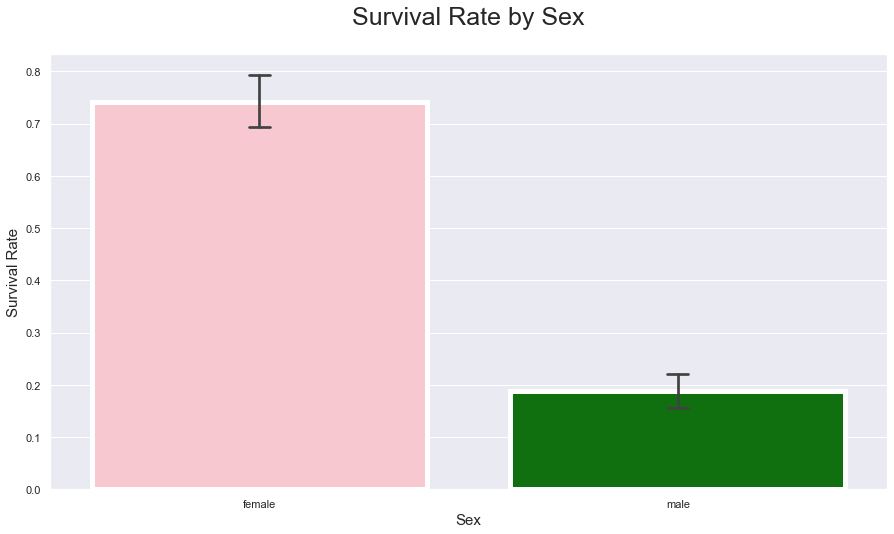

In [31]:
per_sex = train_df[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)
display(per_sex)

pal = {'male':'green', 'female': 'Pink'}
sns.set(style='darkgrid')
plt.subplots(figsize=(15,8))
ax = sns.barplot(x='Sex', 
                 y='Survived', 
                 data=train_df, 
                 palette=pal, 
                 linewidth=5, 
                 order=['female', 'male'], 
                 capsize=.05)
plt.title('Survival Rate by Sex', fontsize=25, loc='center', pad=30)
plt.ylabel('Survival Rate', fontsize=15)
plt.xlabel('Sex', fontsize=15)                                                                                

### Pclass에 따른 생존율
KDE plot에서 볼 수 있듯이, Pclass-3에 탑승한 승객들이 Pclass-2에 탑승한 승객들보다 더 많이 생존할 수 있었던 이유는 Pclass-3에 탑승한 인원이 Pclass-2의 인원보다 훨씬 많았기 때문이다.

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


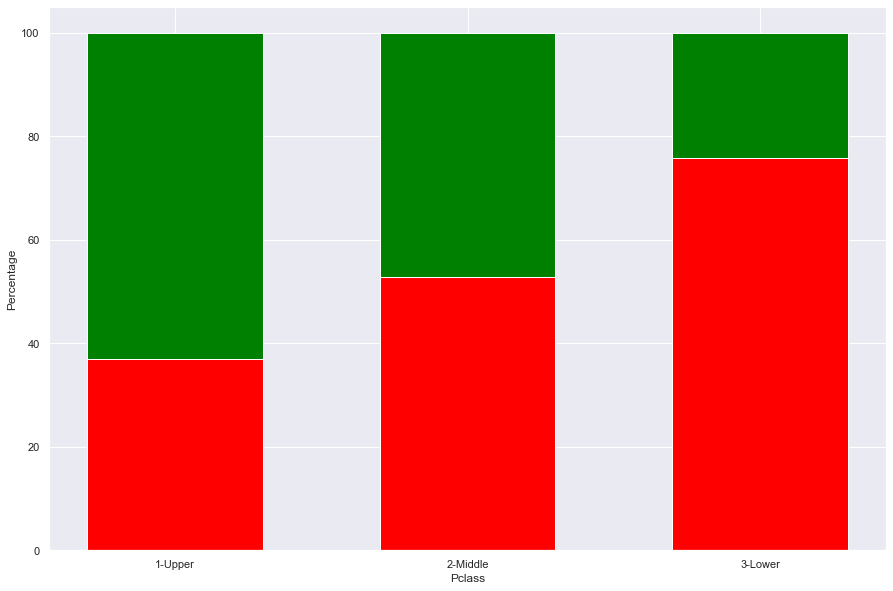

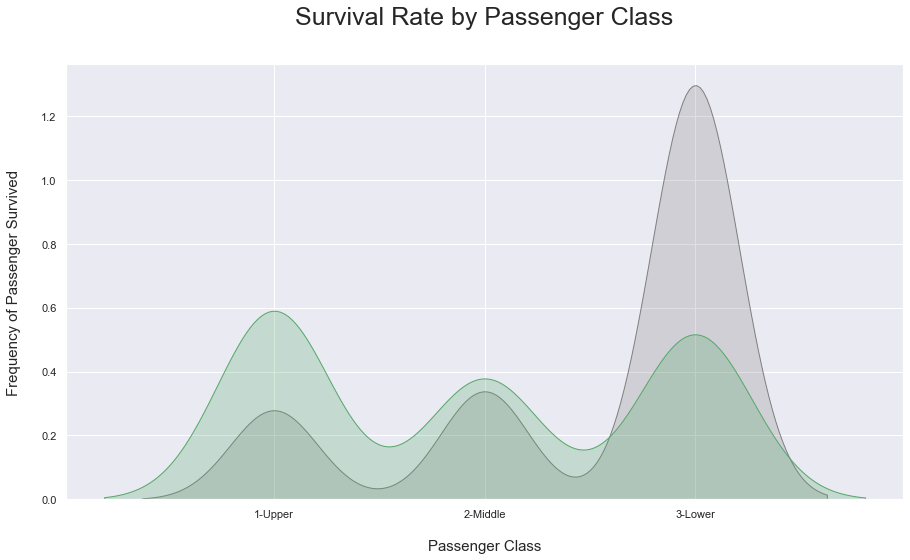

In [32]:
per_class = train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)
display(per_class)

# barplot
tmp = train_df[['Pclass', 'Survived', 'PassengerId']].groupby(['Pclass', 'Survived']).count().reset_index()
tmp_df = pd.pivot_table(tmp, values='PassengerId', index='Pclass', columns='Survived')
names = ['No', 'Yes']
tmp_df.columns = names
r = [0,1,2]
totals = [i+j for i, j in zip(tmp_df['No'], tmp_df['Yes'])]
No_s = [i / j * 100 for i,j in zip(tmp_df['No'], totals)]
Yes_s = [i / j * 100 for i, j in zip(tmp_df['Yes'], totals)]


plt.subplots(figsize=(15,10))
barWidth = 0.60
names= ('1-Upper', '2-Middle', '3-Lower')

plt.bar(r, No_s, color='Red', edgecolor='white', width=barWidth)
plt.bar(r, Yes_s, bottom=No_s, color='Green', edgecolor='white', width=barWidth)

plt.xticks(r, names)
plt.xlabel('Pclass')
plt.ylabel('Percentage')

# KDE plot
fig = plt.figure(figsize=(15,8))
ax = sns.kdeplot(train_df['Pclass'][train_df['Survived'] == 0], 
               color='gray',
               shade=True,
               label='not Survived')
ax = sns.kdeplot(train_df.loc[(train_df['Survived'] == 1),'Pclass'], 
               color='g',
               shade=True, 
               label='Survived', 
              )
plt.title('Survival Rate by Passenger Class', fontsize = 25, pad = 40)
plt.ylabel("Frequency of Passenger Survived", fontsize = 15, labelpad = 20)
plt.xlabel("Passenger Class", fontsize = 15,labelpad =20)
labels = ['1-Upper', '2-Middle', '3-Lower']
plt.xticks(sorted(train_df['Pclass'].unique()), labels);

### 요금에 따른 생존율
* 100불 이하로 요금을 지불한 승객은 대부분 생존하지 못했음을 알 수 있다.
* 반면 280불 이상으로는 회색 그래프가 보이지 않는 것으로 보아, 모든 승객이 생존하였거나 이상치가 존재하여 우리의 판단을 흐리고 있을 수 있다. 확인 결과 512불이라는 이상치가 존재 하고 있었다.

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
258,259,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,C
679,680,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,C
737,738,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,C


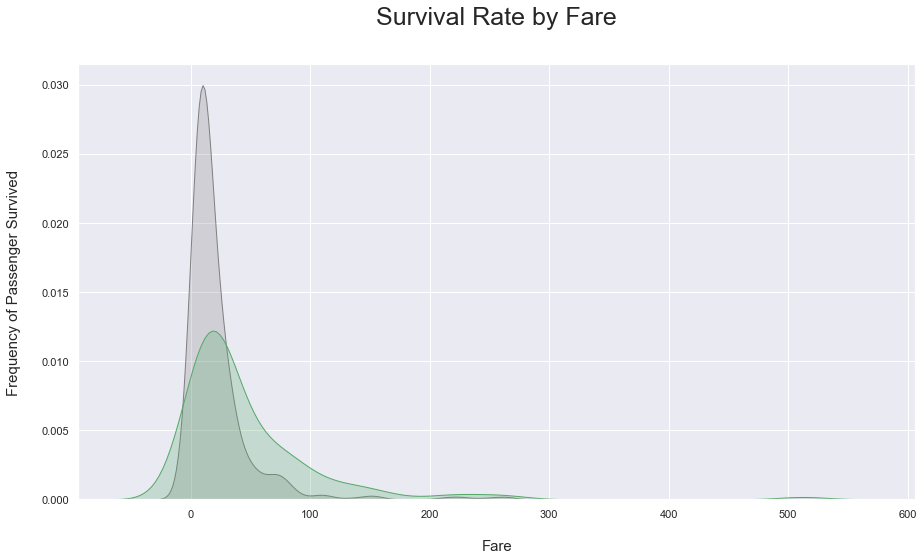

In [33]:
# Kernel Density Plot
fig = plt.figure(figsize=(15,8))
ax=sns.kdeplot(train_df.loc[(train_df['Survived'] == 0),'Fare'], color='gray', shade=True, label='Not Survived')
ax=sns.kdeplot(train_df.loc[(train_df['Survived'] == 1),'Fare'], color='g', shade=True, label='Survived')
plt.title('Survival Rate by Fare', fontsize = 25, pad = 40)
plt.ylabel("Frequency of Passenger Survived", fontsize = 15, labelpad = 20)
plt.xlabel("Fare", fontsize = 15, labelpad = 20)

# outlier
display(train_df[train_df.Fare > 280])

### 나이에 따른 생존율
그래프 확인 결과, 가장 왼쪽에 분포하는 유아 및 어린이들을 제외하고 특이한 현상을 알 수 없다.

Text(0, 0.5, 'Frequency')

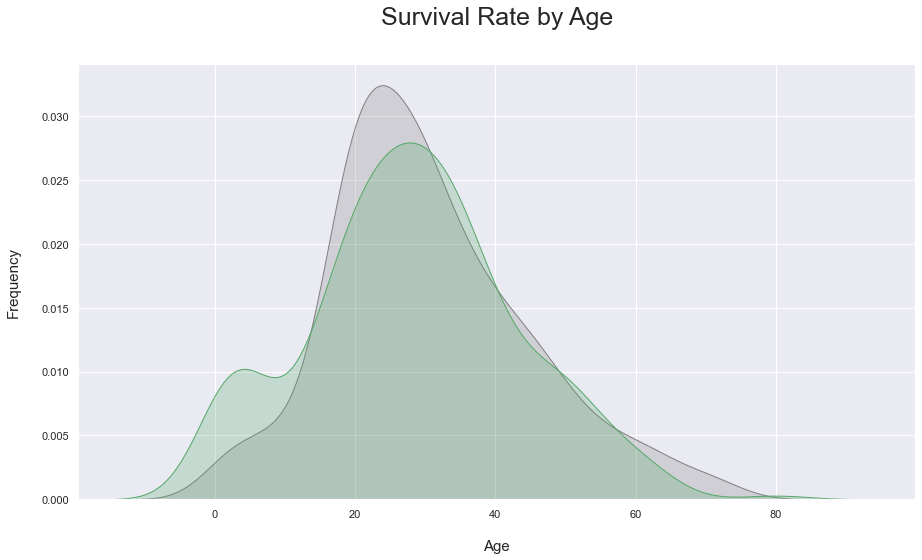

In [34]:
# Kernel Density Plot
fig = plt.figure(figsize=(15,8))
ax=sns.kdeplot(train_df.loc[(train_df['Survived'] == 0),'Age'], color='gray',shade=True,label='Not survived')
ax=sns.kdeplot(train_df.loc[(train_df['Survived'] == 1),'Age'], color='g',shade=True, label='Survived')
plt.title('Survival Rate by Age', fontsize = 25, pad = 40)
plt.xlabel("Age", fontsize = 15, labelpad = 20)
plt.ylabel('Frequency', fontsize = 15, labelpad= 20)

### 생존율에 영향을 미치지 않을 것이라고 가정한 피쳐들

#### SibSp, Parch
* family_size = SibSp + Parch
* 가족 구성원이 5명 이상일 경우 급격히 생존율이 낮아진다.
* 그러나, 가족 구성원이 2~4명일 경우 생존율이 50% 이상으로 높다.

In [52]:
# New column called 'family_size'
train_df['family_size'] = train_df['SibSp'] + train_df['Parch'] + 1
test_df['family_size'] = test_df['SibSp'] + test_df['Parch'] + 1

fam_per = train_df[['family_size', 'Survived']].groupby(['family_size'], as_index=False).mean().sort_values(by='Survived', ascending=False)
display(fam_per)

,family_size,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


#### Embarked
1. Sex and Age
    * 대부분의 사람들이 S 탑승구에서 승차했음
    * S 탑승구의 승객들 중 60% 이상이 죽음
    * C 탑승구의 승객들 중 60% 이상이 생존
    * Q 탑승구의 남성 승객들 대부분이 죽음
    * Q 탑승구의 여성 승객들의 비율은 매우 적지만 대부분 생존
2. Sex, Age and Fare
    * 위에서 보았듯이 500불 이상의 요금에 대한 아웃라이어 3개가 존재
    * 대부분의 승객들이 100불 언저리에서 요금을 지불
3. Sex and Pclass
    * C 탑승구의 남성들을 제외하고 여성 승객이 남성 승객보다 생존율이 높음
    * Q 탑승구의 남성들 중 Pclass3에 있는 남성들의 생존율이 가장 높음
    * 일반적으로 남성 승객들의 생존율은 탑승구와 Pclass의 상관 없이 다양하다.

In [36]:
emb_per = train_df[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)
display(emb_per)

,Embarked,Survived
0,C,0.558824
1,Q,0.389610
2,S,0.336957


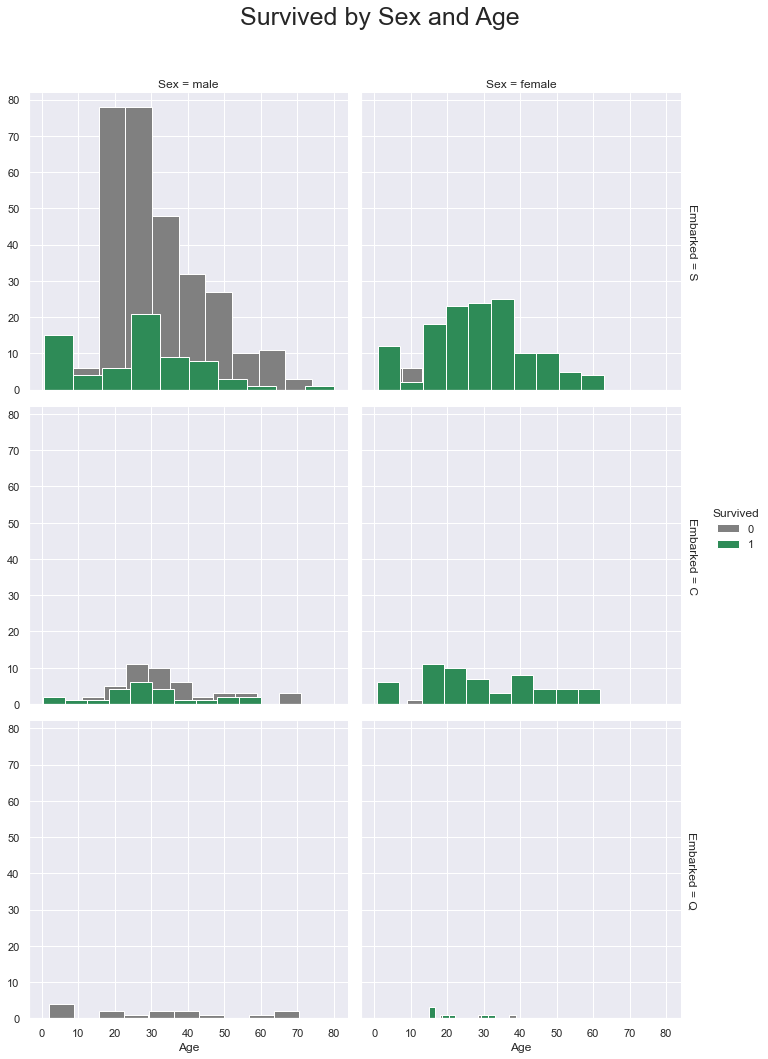

In [37]:
pal = {1:"seagreen", 0:"gray"}
g1 = sns.FacetGrid(train_df, size=5, col="Sex", row="Embarked", 
                   margin_titles=True, hue = "Survived", 
                   palette = pal)              
g1 = g1.map(plt.hist, "Age", edgecolor = 'white').add_legend();
g1.fig.suptitle("Survived by Sex and Age", size = 25)
plt.subplots_adjust(top=0.90)

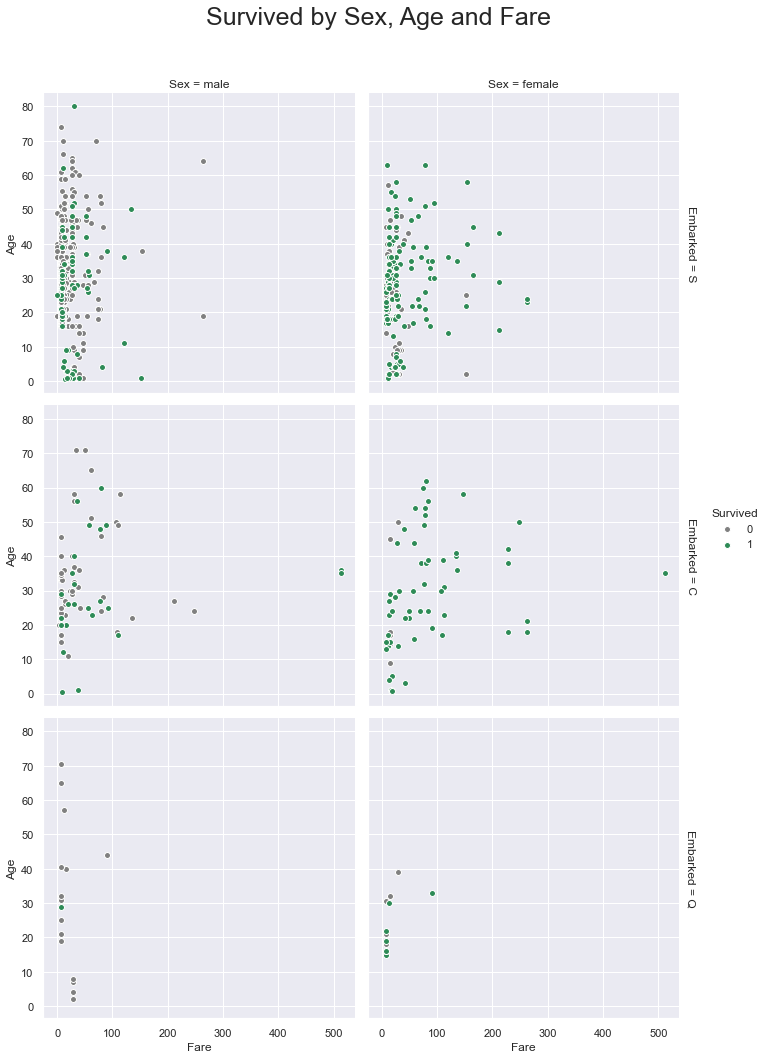

In [38]:
pal = {1:"seagreen", 0:"gray"}
g2 = sns.FacetGrid(train_df, size=5,hue="Survived", 
                   col ="Sex", row="Embarked",
                   margin_titles=True, palette=pal)
                
g2.map(plt.scatter, "Fare", "Age",edgecolor="w").add_legend()
g2.fig.suptitle("Survived by Sex, Age and Fare", size = 25)
plt.subplots_adjust(top=0.90)

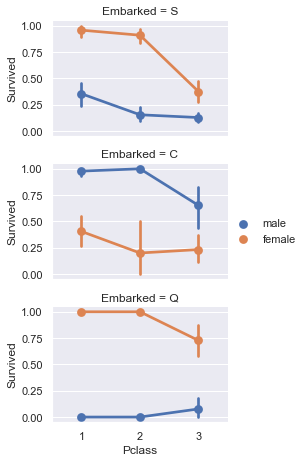

In [39]:
g3 = sns.FacetGrid(train_df, row='Embarked', size=2.2, aspect=1.6)
g3.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
g3.add_legend()

### Correlation Matrix
* female -> 0
* male -> 1

<b>성별이 생존율에 가장 많은 영향을 미쳤다.</b>

In [40]:
train_df['Sex'] = train_df['Sex'].apply(lambda x: 0 if x == 'female' else 1)
test_df['Sex'] = test_df['Sex'].apply(lambda x: 0 if x == 'female' else 1)

# 각 피쳐에 대한 생존 여부 평균
survived_summary = train_df.groupby('Survived')
display(survived_summary.mean().reset_index())

# 상관분석
corr_data = pd.DataFrame(abs(train_df.corr()['Survived']).sort_values(ascending = False))
display(corr_data)

,Survived,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,family_size
0,0,447.016393,2.531876,0.852459,30.626179,0.553734,0.329690,22.117887,1.883424
1,1,444.368421,1.950292,0.318713,28.343690,0.473684,0.464912,48.395408,1.938596


,Survived
Survived,1.000000
Sex,0.543351
Pclass,0.338481
Fare,0.257307
Parch,0.081629
Age,0.077221
SibSp,0.035322
family_size,0.016639
PassengerId,0.005007


### Correlation Heatmap
#### 양의 상관관계
* Fare and Survivaed: 0.26

#### 음의 상관관계
* Fare and Pclass: -0.55
* Sex and Survived: -0.54
* Pclass and Survived: -0.34

Text(0.5, 1.03, 'Correlations Among Features')

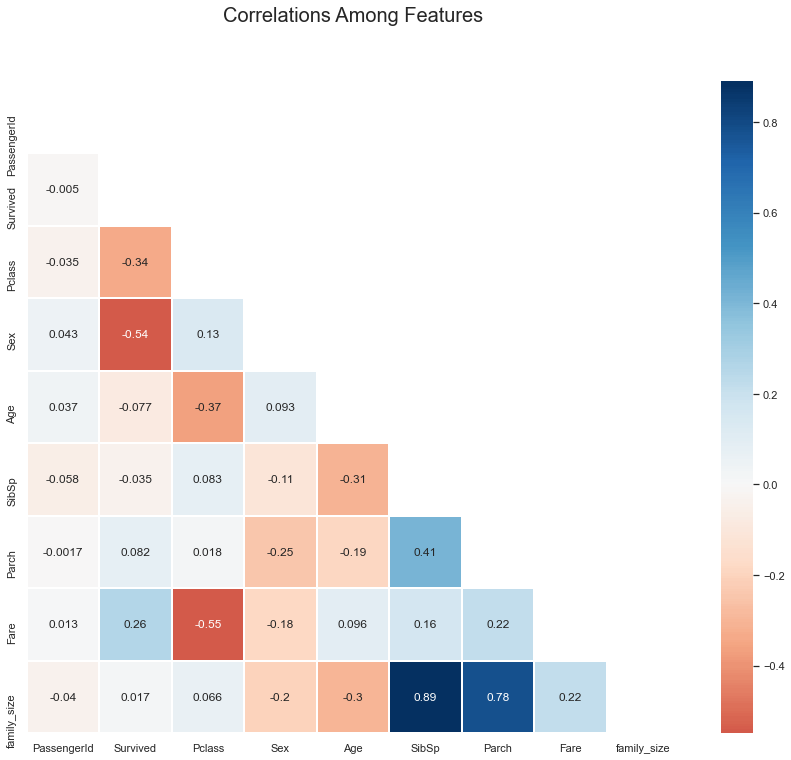

In [41]:
mask = np.zeros_like(train_df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.set_style('whitegrid')
plt.subplots(figsize = (15,12))
sns.heatmap(train_df.corr(), 
            annot=True,
            mask = mask,
            cmap = 'RdBu', ## in order to reverse the bar replace "RdBu" with "RdBu_r"
            linewidths=.9, 
            linecolor='white',
            fmt='.2g',
            center = 0,
            square=True)
plt.title("Correlations Among Features", y = 1.03, fontsize = 20, pad = 40)

## Feature Engineering
### title
* 타이틀 정리: ['Mr' 'Mrs' 'Miss' 'Master' 'rare']
* 타이틀 숫자화: "Mr": 0, "Miss": 1, "Mrs": 2, "Master": 3, "rare": 4

In [53]:
# New column called 'title'
train_df["title"] = [i.split('.')[0] for i in train_df['Name']]
train_df["title"] = [i.split(',')[1] for i in train_df['title']]
test_df["title"] = [i.split('.')[0] for i in test_df['Name']]
test_df["title"] = [i.split(',')[1] for i in test_df['title']]
print(train_df['title'].unique())

# Remove whitespace
train_df['title'] = train_df['title'].apply(lambda x: x.strip())
test_df['title'] = test_df['title'].apply(lambda x: x.strip())

# Unify title
def uni_title(feature):
    result = ''
    
    if feature in ['the Countess','Capt','Lady','Sir','Jonkheer','Don','Major','Col', 'Rev', 'Dona', 'Dr']:
        result = 'rare'
    elif feature in ['Ms', 'Mlle']:
        result = 'Miss'
    elif feature == 'Mme':
        result = 'Mrs'
    else:
        result = feature
        
    return result

train_df['title'] = train_df['title'].map(uni_title)
test_df['title'] = test_df['title'].map(uni_title)
print(test_df['title'].unique())

# Convert the categorical titles to ordinal
title_mapping = {"Mr": 0, "Miss": 1, "Mrs": 2, "Master": 3, "rare": 4}
train_df['title'] = train_df['title'].map(title_mapping)
test_df['title'] = test_df['title'].map(title_mapping)

train_df.head()

[' Mr' ' Mrs' ' Miss' ' Master' ' Don' ' Rev' ' Dr' ' Mme' ' Ms' ' Major'
 ' Lady' ' Sir' ' Mlle' ' Col' ' Capt' ' the Countess' ' Jonkheer']
['Mr' 'Mrs' 'Miss' 'Master' 'rare']


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,family_size,title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,2,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,2,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,2,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,1,0


### SibSp, Parch
* family_size: 0 => is_alone
* family_size: {1: 2~4, 2: 5명 이상}

In [54]:
def family_group(size):
    s = 0
    if (size >= 2 and size <=4):
        s = 1
    elif (size >= 5):
        s = 2
    else:
        s = 0
    return s

train_df['family_size'] = train_df['family_size'].map(family_group)
test_df['family_size'] = test_df['family_size'].map(family_group)

train_df['is_alone'] = 0
test_df['is_alone'] = 0
train_df.loc[train_df['family_size'] == 0, 'is_alone'] = 1
test_df.loc[test_df['family_size'] == 0, 'is_alone'] = 1

alone_per = train_df[['is_alone', 'Survived']].groupby(['is_alone'], as_index=False).mean()
display(alone_per)

# remove family_size column
train_df = train_df.drop(['family_size'], axis=1)
test_df = test_df.drop(['family_size'], axis=1)
display(train_df)

,is_alone,Survived
0,0,0.505650
1,1,0.303538


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,title,is_alone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,2,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,2,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,S,4,1
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,S,1,1
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,S,1,0
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C,0,1


### Now, drop unrelavent columns
* Ticket
* Name
* PassengerId
* SibSp, Parch
* (참고) Cabin은 위에서 이미 삭제함

In [55]:
train_df = train_df.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket'], axis=1)
test_df = test_df.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket'], axis=1)
display(train_df)

,Survived,Pclass,Sex,Age,Fare,Embarked,title,is_alone
0,0,3,male,22.0,7.2500,S,0,0
1,1,1,female,38.0,71.2833,C,2,0
2,1,3,female,26.0,7.9250,S,1,1
3,1,1,female,35.0,53.1000,S,2,0
4,0,3,male,35.0,8.0500,S,0,1
...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,13.0000,S,4,1
887,1,1,female,19.0,30.0000,S,1,1
888,0,3,female,NaN,23.4500,S,1,0
889,1,1,male,26.0,30.0000,C,0,1


### Sex
* 남성: 0
* 여성: 1

In [56]:
sex_mapping = {'male': 0, 'female': 1}
train_df['Sex'] = train_df['Sex'].map(sex_mapping).astype(int)
test_df['Sex'] = test_df['Sex'].map(sex_mapping).astype(int)
display(train_df)

,Survived,Pclass,Sex,Age,Fare,Embarked,title,is_alone
0,0,3,0,22.0,7.2500,S,0,0
1,1,1,1,38.0,71.2833,C,2,0
2,1,3,1,26.0,7.9250,S,1,1
3,1,1,1,35.0,53.1000,S,2,0
4,0,3,0,35.0,8.0500,S,0,1
...,...,...,...,...,...,...,...,...
886,0,2,0,27.0,13.0000,S,4,1
887,1,1,1,19.0,30.0000,S,1,1
888,0,3,1,NaN,23.4500,S,1,0
889,1,1,0,26.0,30.0000,C,0,1


### Age
* 결측치 처리
* 그룹으로 분류

#### 결측치 처리
'title'과 Pclass의 중앙값으로 결측값을 매움
* title: Mr(0), Miss(1), Mrs(2), Master(3), rare(4)
* Pclass: 1, 2, 3

In [57]:
guess_age = np.zeros((3, 5))

# train_df
for i in range(0, 3): # Pclass
    for j in range(0, 5): # title
        guess_df = train_df[(train_df['Pclass'] == i+1) & \
                           (train_df['title'] == i)]['Age'].dropna()
        
        age_guess = guess_df.median()
        
        # 실수를 0.5 age로 반올림
        guess_age[i, j] = int(age_guess/0.5 + 0.5) * 0.5

for i in range(0, 3):
    for j in range(0, 5):
        train_df.loc[(train_df['Age'].isnull()) & 
                     (train_df['Pclass'] == i+1) & 
                     (train_df['title'] == j), 'Age'] = guess_age[i, j] 
train_df['Age'] = train_df['Age'].astype(int)

    
# test_df
for i in range(0, 3): # Pclass
    for j in range(0, 5): # title
        guess_df = test_df[(test_df['Pclass'] == i+1) & \
                           (test_df['title'] == i)]['Age'].dropna()
        
        age_guess = guess_df.median()
        
        # 실수를 0.5 age로 반올림
        guess_age[i, j] = int(age_guess/0.5 + 0.5) * 0.5

for i in range(0, 3):
    for j in range(0, 5):
        test_df.loc[(test_df['Age'].isnull()) & 
                     (test_df['Pclass'] == i+1) & 
                     (test_df['title'] == j), 'Age'] = guess_age[i, j] 
test_df['Age'] = test_df['Age'].astype(int)

display(train_df.head())

,Survived,Pclass,Sex,Age,Fare,Embarked,title,is_alone
0,0,3,0,22,7.2500,S,0,0
1,1,1,1,38,71.2833,C,2,0
2,1,3,1,26,7.9250,S,1,1
3,1,1,1,35,53.1000,S,2,0
4,0,3,0,35,8.0500,S,0,1


#### 생존율에 따라 나이를 그룹으로 분류
 * pd.cut(): 동일한 길이로 나누기
 * pd.qcut(): 동일한 개수로 나누기 <br>

👉🏼[참고자료](https://rfriend.tistory.com/404)

In [58]:
train_df['age_band'] = pd.cut(train_df['Age'], 5)
age_band_per = train_df[['age_band', 'Survived']].groupby(['age_band'], as_index=False).mean().sort_values(by='age_band', ascending=True)
display(age_band_per)

,age_band,Survived
0,"(-0.08, 16.0]",0.550000
1,"(16.0, 32.0]",0.337374
2,"(32.0, 48.0]",0.412037
3,"(48.0, 64.0]",0.434783
4,"(64.0, 80.0]",0.090909


In [59]:
# train_df
train_df.loc[ train_df['Age'] <= 16, 'Age'] = 0
train_df.loc[(train_df['Age'] > 16) & (train_df['Age'] <= 32), 'Age'] = 1
train_df.loc[(train_df['Age'] > 32) & (train_df['Age'] <= 48), 'Age'] = 2
train_df.loc[(train_df['Age'] > 48) & (train_df['Age'] <= 64), 'Age'] = 3
train_df.loc[ train_df['Age'] > 64, 'Age']
# remove age_band column
train_df = train_df.drop(['age_band'], axis=1)


# test_df
test_df.loc[ test_df['Age'] <= 16, 'Age'] = 0
test_df.loc[(test_df['Age'] > 16) & (test_df['Age'] <= 32), 'Age'] = 1
test_df.loc[(test_df['Age'] > 32) & (test_df['Age'] <= 48), 'Age'] = 2
test_df.loc[(test_df['Age'] > 48) & (test_df['Age'] <= 64), 'Age'] = 3
test_df.loc[ test_df['Age'] > 64, 'Age']

display(test_df.head())

,Pclass,Sex,Age,Fare,Embarked,title,is_alone
0,3,0,2,7.8292,Q,0,1
1,3,1,2,7.0000,S,2,0
2,2,0,3,9.6875,Q,0,1
3,3,0,1,8.6625,S,0,1
4,3,1,1,12.2875,S,2,0


### Embarked
* S: 0
* C: 1
* Q: 2

In [60]:
embarked_mapping = {'S': 0, 'C': 1, 'Q': 2}
train_df['Embarked'] = train_df['Embarked'].map(embarked_mapping).astype(int)
test_df['Embarked'] = test_df['Embarked'].map(embarked_mapping).astype(int)

display(train_df.head())

,Survived,Pclass,Sex,Age,Fare,Embarked,title,is_alone
0,0,3,0,1,7.2500,0,0,0
1,1,1,1,2,71.2833,1,2,0
2,1,3,1,1,7.9250,0,1,1
3,1,1,1,2,53.1000,0,2,0
4,0,3,0,2,8.0500,0,0,1


### Fare
생존율에 따라 요금을 그룹으로 분류 <br>
🙋🏻‍♀️pd.qcut()

In [61]:
train_df['fare_band'] = pd.qcut(train_df['Fare'], 4)
fare_band_per = train_df[['fare_band', 'Survived']].groupby(['fare_band'], as_index=False).mean().sort_values(by='fare_band', ascending=True)
display(fare_band_per)

,fare_band,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


In [62]:
combine = [train_df, test_df]
for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

train_df = train_df.drop(['fare_band'], axis=1)
combine = [train_df, test_df]
    
train_df.head(10)

,Survived,Pclass,Sex,Age,Fare,Embarked,title,is_alone
0,0,3,0,1,0,0,0,0
1,1,1,1,2,3,1,2,0
2,1,3,1,1,1,0,1,1
3,1,1,1,2,3,0,2,0
4,0,3,0,2,1,0,0,1
5,0,3,0,1,1,2,0,1
6,0,1,0,3,3,0,0,1
7,0,3,0,0,2,0,3,0
8,1,3,1,1,1,0,2,0
9,1,2,1,0,2,1,2,0


## Splitting Data for learning and validation

In [63]:
# 7: Training Data Set
# 3: Validation Data Set

train_data = train_df.iloc[:int(train_df.shape[0] * 0.7)] 
val_data = train_df.iloc[int(train_df.shape[0] * 0.7):] 

# Training Data Set
train_x_data = train_data.drop(['Survived'], axis=1, inplace=False).values
train_t_data = train_data['Survived'].values.reshape(-1,1) 

# Validation Data Set
val_x_data = val_data.drop(['Survived'], axis=1, inplace=False).values 
val_t_data = val_data['Survived'].values.reshape(-1,1)

print(train_x_data.shape, train_t_data.shape, val_x_data.shape, val_t_data.shape)

(623, 7) (623, 1) (268, 7) (268, 1)


## Data Preprocssing
* 결측치 (checked)
* 이상치 (checked)
* 정규화 (not necessary)

In [64]:
# Z-score Normalization = Standardization
std_scaler = StandardScaler()

# train_df
train_x_data = std_scaler.fit_transform(train_x_data)
val_x_data = std_scaler.fit_transform(val_x_data)

print(train_x_data)

[[ 0.82770401 -0.76764947 -0.14835787 ... -0.58353933 -0.72715525
  -1.18549796]
 [-1.57071272  1.30267789 -0.00616256 ...  0.9700718   1.30887944
  -1.18549796]
 [ 0.82770401  1.30267789 -0.14835787 ... -0.58353933  0.2908621
   0.84352739]
 ...
 [ 0.82770401 -0.76764947 -0.14835787 ...  0.9700718  -0.72715525
  -1.18549796]
 [-1.57071272 -0.76764947 -0.00616256 ... -0.58353933 -0.72715525
  -1.18549796]
 [ 0.82770401 -0.76764947 -0.14835787 ...  0.9700718  -0.72715525
  -1.18549796]]


## Logistic Regression Model

In [65]:
# X, T
X = tf.placeholder(shape=[None, 7], dtype=tf.float32)
T = tf.placeholder(shape=[None, 1], dtype=tf.float32)

# W, b
W = tf.Variable(tf.random.normal([7,1]), name='weight')
b = tf.Variable(tf.random.normal([1]), name='bias')

# Hypothesis
logit = tf.matmul(X, W) + b
H = tf.sigmoid(logit)

# log loss
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logit, labels=T))

# gradient descent algorithm
train = tf.train.GradientDescentOptimizer(learning_rate=1e-4).minimize(loss)

# learning
sess = tf.Session()
sess.run(tf.global_variables_initializer())

for step in range(300000):
    _, W_val, b_val, loss_val = sess.run([train, W, b, loss], feed_dict={X: train_x_data, T: train_t_data})
    
    if step % 30000 == 0:
        print('W: {}, b: {}, loss: {}'.format(W_val.ravel(), b_val, loss_val))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W: [-0.12093866  1.1626477  -0.82709694  0.0825243  -0.06670616 -0.12527151
  0.05004249], b: [0.46978068], loss: 0.6055662035942078
W: [-0.3354265   1.2153084  -0.781159    0.16561873  0.04617802  0.04788723
  0.03825682], b: [0.03936661], loss: 0.5051422119140625
W: [-0.4551166   1.1968263  -0.7574809   0.1693036   0.11261851  0.13064495
  0.06796769], b: [-0.20893656], loss: 0.4748186469078064
W: [-0.5337585   1.171304   -0.7458635   0.15456323  0.1550715   0.18805736
  0.09408516], b: [-0.3625551], loss: 0.4624366760253906
W: [-0.58943623  1.1504302  -0.74158     0.13522913  0.18291058  0.23379466
  0.11133859], b: [-0.45983928], loss: 0.45684486627578735
W: [-0.63090646  1.1350626  -0.74188995  0.11518455  0.20134829  0.27095598
  0.12146424], b: [-0.52237344], loss: 0.4541188180446625
W: [-0.663061    1.1242437  -0.7449936   0.09571317  0.21360035  0.30077177
  0.1267203 ], b: [-0.563192

## Model Evaluation

In [67]:
predict = tf.cast(H > 0.5, dtype=tf.float32) 
correct = tf.equal(predict, T)  
for_acc = tf.cast(correct, dtype=tf.float32) 

# Accuracy
accuracy = tf.reduce_mean(for_acc)
accuracy_val = sess.run(accuracy, feed_dict={X: val_x_data, T: val_t_data})

print('Accuracy: {}'.format(accuracy_val)) # 78%

Accuracy: 0.7835820913314819


## Testing

#### 예전 버전 (X)

In [286]:
scaled_predict_data = std_scaler.transform(test_df)
result = sess.run(H, feed_dict={X: scaled_predict_data})
print(result)

[[0.0525375 ]
 [0.15595713]
 [0.08117464]
 [0.04556042]
 [0.20103714]
 [0.06029519]
 [0.24548003]
 [0.08650431]
 [0.2521835 ]
 [0.04287693]
 [0.04499739]
 [0.13850015]
 [0.53575224]
 [0.04980144]
 [0.46194416]
 [0.40396413]
 [0.10614657]
 [0.05594584]
 [0.16178569]
 [0.20056409]
 [0.12370774]
 [0.11503136]
 [0.4810142 ]
 [0.20322898]
 [0.5191887 ]
 [0.02419442]
 [0.5268212 ]
 [0.05594584]
 [0.13850015]
 [0.05333826]
 [0.04980144]
 [0.08753917]
 [0.15941715]
 [0.20313743]
 [0.20322898]
 [0.05594584]
 [0.17243564]
 [0.17243564]
 [0.04556042]
 [0.04670674]
 [0.03973088]
 [0.13850015]
 [0.03386635]
 [0.36475787]
 [0.46194416]
 [0.04556042]
 [0.16819242]
 [0.06936476]
 [0.46444994]
 [0.15941715]
 [0.16860518]
 [0.11392766]
 [0.29246086]
 [0.46955693]
 [0.11392766]
 [0.17426813]
 [0.03386635]
 [0.04499739]
 [0.04287693]
 [0.47206777]
 [0.04499739]
 [0.0916568 ]
 [0.04499739]
 [0.24548003]
 [0.43169647]
 [0.36778125]
 [0.24548003]
 [0.14006165]
 [0.21370745]
 [0.3897674 ]
 [0.24548003]
 [0.04

In [298]:
test = pd.read_csv('titanic/test.csv')
new_df = pd.DataFrame(result, index=test['PassengerId'], columns=['Survived'])
display(new_df)

new_df['Survived'] = new_df['Survived'].apply(lambda x: 1 if x >= 0.5 else 0)
display(new_df)

,Survived
PassengerId,
892,0.052538
893,0.155957
894,0.081175
895,0.045560
896,0.201037
...,...
1305,0.045560
1306,0.664560
1307,0.033866


,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,0
...,...
1305,0
1306,1
1307,0


#### 현재 버전 (O)

In [68]:
scaled_predict_data = std_scaler.transform(test_df)
test_t_data = sess.run(predict, feed_dict={X: scaled_predict_data})
print(test_t_data)

[[0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.

In [70]:
new_df = pd.read_csv('titanic/test.csv')
new_df['Survived'] = test_t_data.astype(int)
display(new_df)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,0
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,1
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,0
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,0


## Submission

#### 예전 버전 (X)

In [305]:
submission = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Survived': new_df['Survived'].values
})

display(submission)

submission.to_csv('titanic/titanic_submission.csv', index=False)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


#### 현재 버전 (O)

In [73]:
submission = pd.DataFrame({
    'PassengerId': new_df['PassengerId'],
    'Survived': new_df['Survived']
})

display(submission)

submission.to_csv('titanic/titanic_submission.csv', index=False)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


-----
Reference <br>
[1] [A Statistical Analysis & ML workflow of Titanic](https://www.kaggle.com/masumrumi/a-statistical-analysis-ml-workflow-of-titanic) <br>
[2] [Titanic Data Science Solutions](https://www.kaggle.com/startupsci/titanic-data-science-solutions)